In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [3]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2024-04-08 00:05:46.471967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 00:05:46.472064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 00:05:46.618492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Zipfile

In [6]:
def extrct_zipfile(path):
    with zipfile.ZipFile(path,'r') as zipref:
        zipref.extractall('./data')

  # List of paths to ZIP archives      
paths = [
    '/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',
    '/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip'
]

# Extract files from each ZIP archive
_ = [extrct_zipfile(path) for path in paths]

# EDA

In [8]:
train = pd.read_csv('/kaggle/working/data/train.tsv', sep='\t')
test = pd.read_csv('/kaggle/working/data/test.tsv', sep='\t')
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [9]:
train.shape, test.shape

((156060, 4), (66292, 3))

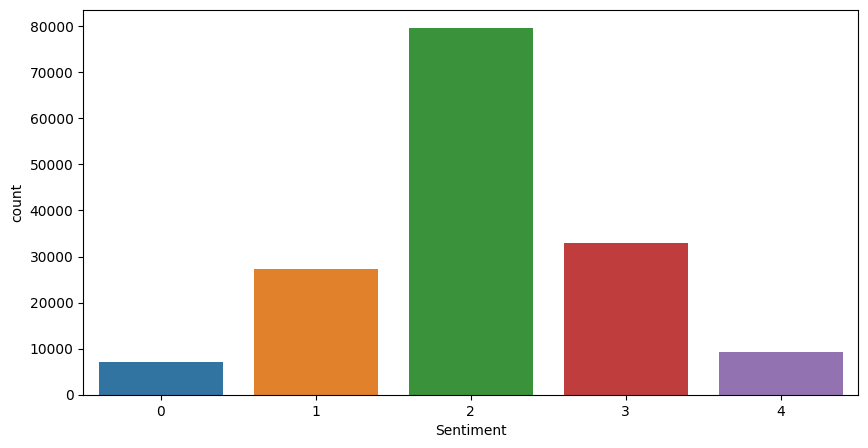

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

sns.countplot(x = 'Sentiment', data=train, ax=ax)
plt.show()

We can see that the majority of the sentiment score is 2 which is neutral

# Text Wrangling
* remove html content
* remove non-alphabetic characters
* tokenize the sentences
* lemmatize each word to its lemma

In [11]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

In [12]:
def text_cleaning(df):
    
    cleaned_phrase = []
    for phrase in tqdm(df['Phrase']):
        #remove html
        text = BeautifulSoup(str(phrase)).get_text()
        #remove non-alphabetic character
        text = re.sub("[^a-zA-Z]", " ", text)
        #tokenize sentence
        tokens = word_tokenize(text.lower())
        
        #lemmatize word
        lemma_words = [lemmatizer.lemmatize(i) for i in tokens]
        
        
        cleaned_phrase.append(lemma_words)
        
    return(cleaned_phrase)

In [13]:
train_phrases = text_cleaning(train)
test_phrases = text_cleaning(test)
print(len(train_phrases))
print(len(test_phrases))

  1%|▏         | 2327/156060 [00:03<01:29, 1721.10it/s]/tmp/ipykernel_35/1355952189.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(str(phrase)).get_text()
100%|██████████| 66292/66292 [00:27<00:00, 2440.97it/s]

156060
66292


# One-hot encode categorical target variables

In [14]:
from keras.utils import to_categorical
target_variable = train['Sentiment']
y = to_categorical(target_variable)
num_classes = y.shape[1]

# Train and  Validation Split

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_phrases,y, test_size=0.2, random_state=88)

# Determining the input dimensions for neural network models

In [16]:
# Initialize an empty set to store unique words
unique_words = set()
# Initialize a variable to store the maximum phrase length
max_length = 0

for phrase in tqdm(X_train):
     # Update the set of unique words with the words from the current phrase
    unique_words.update(phrase)
    
 # Check if the length of the current phrase exceeds the current maximum length
    if (max_length < len(phrase)):
         # If so, update the maximum length to the length of the current phrase
        max_length = len(phrase)
        
print("Number of unique words:", len(unique_words))
print("Maximum phrase length:", max_length)

100%|██████████| 124848/124848 [00:00<00:00, 556669.90it/s]

Number of unique words: 13731
Maximum phrase length: 48


# Convert training and test data to sequence
Preprocess the text data by tokenizing the words, converting them into sequences of word indices, and padding them to ensure uniform length, making them ready for use in training neural network models.

In [17]:
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize a Tokenizer object with the number of words set to the length of the unique words set
tokenizer = Tokenizer(num_words=len(list(unique_words)))
# Fit the tokenizer on the training data to generate word indices
tokenizer.fit_on_texts(list(X_train))


# Convert the training, validation, and test data into sequences of word indices using the fitted tokenizer
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
test_data = tokenizer.texts_to_sequences(test_phrases)

# Pad the sequences of word indices to ensure uniform length
X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_val = sequence.pad_sequences(X_val, maxlen=max_length)
test_data = sequence.pad_sequences(test_data, maxlen=max_length)

# Print the shapes of the preprocessed training, validation, and test data
print(X_train.shape, X_val.shape, test_data.shape)


(124848, 48) (31212, 48) (66292, 48)


# Tensorflow Reset Function

In [18]:
import tensorflow.keras.backend as K
import gc

def reset_tensorflow():
    K.clear_session()  # Clear the Keras session
    gc.collect()  # Perform garbage collection to free up memory

# Example usage:
reset_tensorflow()

# Early Stopping

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.001, mode='max', monitor='val_accuracy', patience=2)

callback = [early_stopping]

# Model Building

I know that BERT would be the first choice to implement for this problem because it performs very well. However, I want to explore other models as well. Therefore, I will be building four different models to better understand their code and the differences between each type of model. While I acknowledge that BERT performs very well on this problem, I am interested in learning about other models as well. 

* LSTM
* RNN
* Bidirectional LSTM
* Bidirectional LSTM with Glovec



In [20]:
from keras.layers import Dropout, Dense, Embedding, LSTM, SimpleRNN, GRU, Input, Bidirectional
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Model, Sequential

# LSTM

In [21]:
vocab_size = len(list(unique_words))
embedding_dim = 300


inputs = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
x = LSTM(128,return_sequences=True)(embedding_layer)
x = LSTM(64,return_sequences=False)(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 48, 300)        │     4,119,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 128)        │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,395,361 (16.77 MB)

 Trainable params: 4,395,361 (16.77 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001 ), 
              metrics=['accuracy'])

In [23]:
reset_tensorflow()
history = model.fit(X_train, 
                    y_train,
                   validation_data=(X_val,y_val),
                   epochs=10,
                   batch_size=256,
                   verbose=1, callbacks=callback)

Epoch 1/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5450 - loss: 1.1419 - val_accuracy: 0.6535 - val_loss: 0.8434
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6820 - loss: 0.7810 - val_accuracy: 0.6736 - val_loss: 0.7970
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7121 - loss: 0.6930 - val_accuracy: 0.6784 - val_loss: 0.7881
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7357 - loss: 0.6289 - val_accuracy: 0.6763 - val_loss: 0.8039
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7557 - loss: 0.5781 - val_accuracy: 0.6713 - val_loss: 0.8349


In [24]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

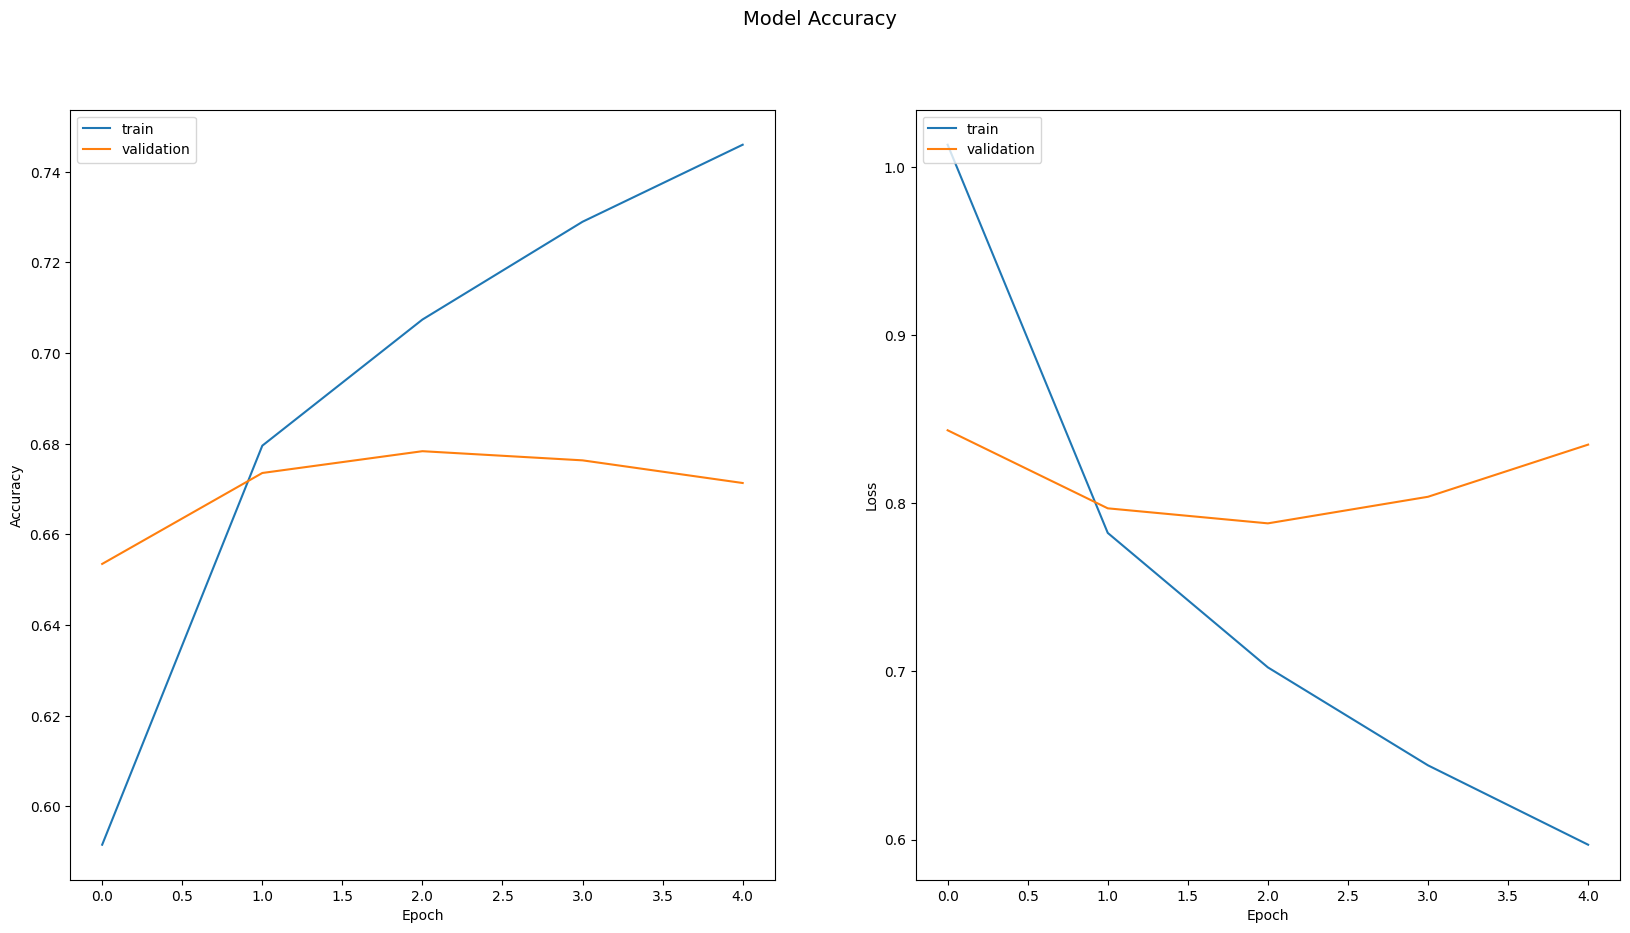

In [25]:
plot_learning_curves(history)

# RNN 

In [26]:
reset_tensorflow()

vocab_size = len(list(unique_words))
embedding_dim = 300


inputs = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
x = SimpleRNN(128,return_sequences=True)(embedding_layer)
x = SimpleRNN(64,return_sequences=False)(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model1 = Model(inputs,outputs)
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 48, 300)        │     4,119,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 48, 128)        │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,193,569 (16.00 MB)

 Trainable params: 4,193,569 (16.00 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model1.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.003 ), 
              metrics=['accuracy'])

In [28]:
reset_tensorflow()
history1 = model1.fit(X_train, 
                    y_train,
                   validation_data=(X_val,y_val),
                   epochs=10,
                   batch_size=256,
                   verbose=1)

Epoch 1/10
  6/488 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.3812 - loss: 1.4637

I0000 00:00:1712534908.747197      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


488/488 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5450 - loss: 1.1356 - val_accuracy: 0.6430 - val_loss: 0.8790
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6627 - loss: 0.8202 - val_accuracy: 0.6532 - val_loss: 0.8450
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6983 - loss: 0.7298 - val_accuracy: 0.6338 - val_loss: 0.9309
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6989 - loss: 0.7304 - val_accuracy: 0.6558 - val_loss: 0.8533
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7177 - loss: 0.6782 - val_accuracy: 0.6416 - val_loss: 0.8841
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7182 - loss: 0.6706 - val_accuracy: 0.6597 - val_loss: 0.8896
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7371 - loss: 0.6213 - val_accuracy: 0.6506 - val_loss: 0.8995
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7497 - loss: 0.5878 - val_accuracy: 0.65

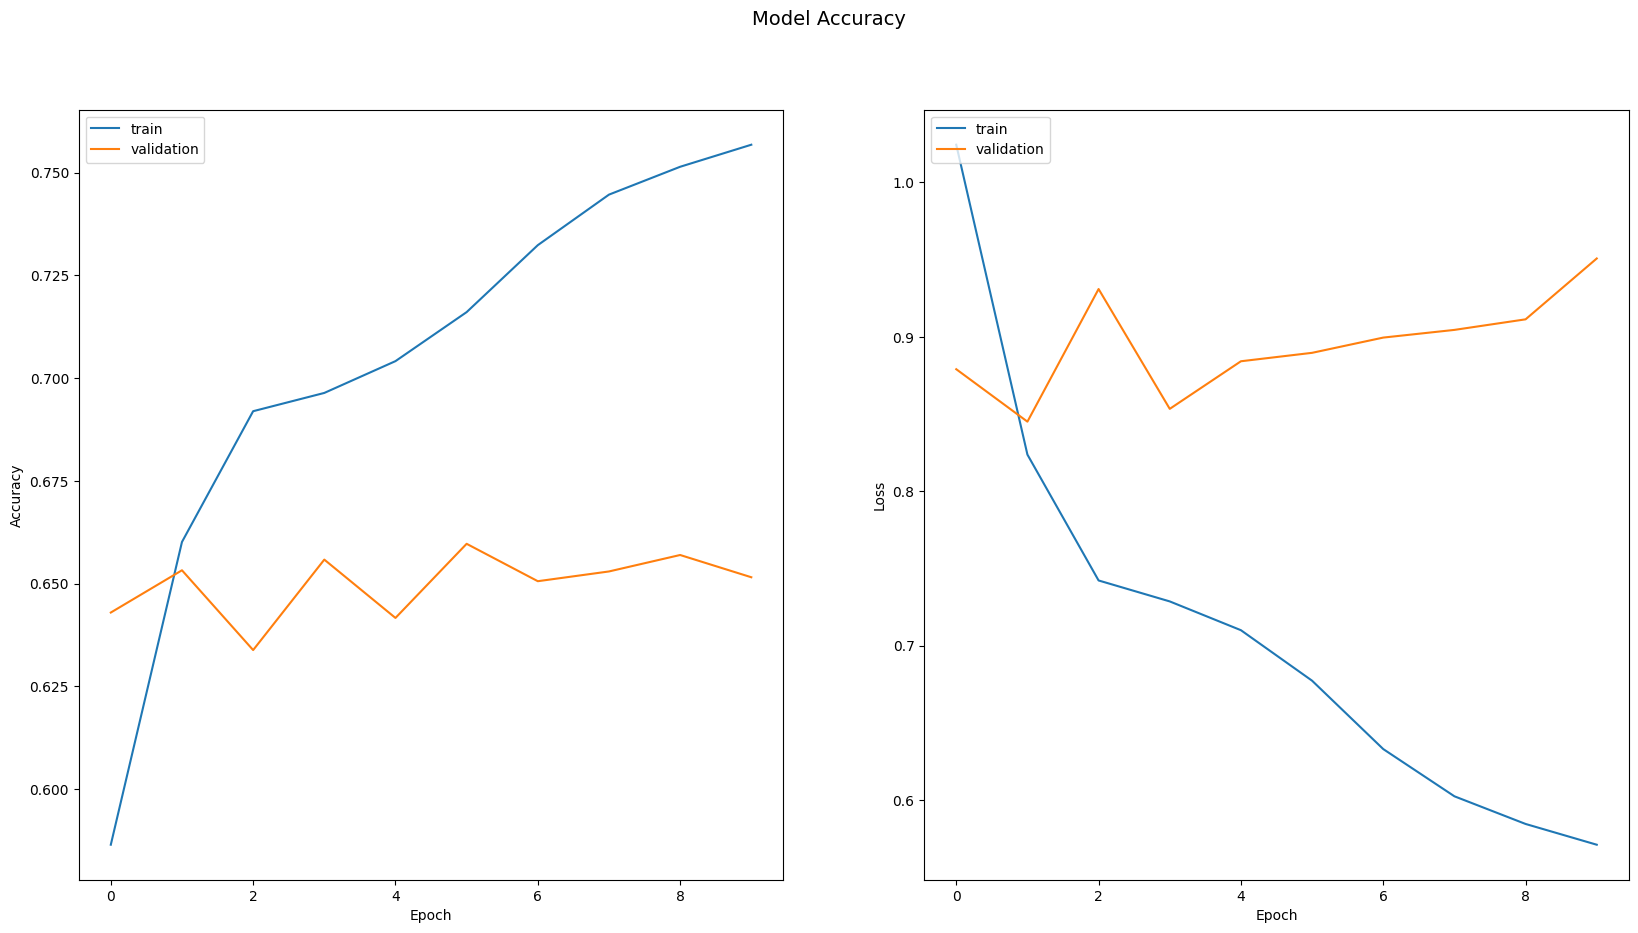

In [29]:
plot_learning_curves(history1)

# Bidirectional LSTM

In [30]:
reset_tensorflow()
vocab_size = len(list(unique_words))
embedding_dim = 300


inputs = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
x = Bidirectional(LSTM(128,return_sequences=True))(embedding_layer)
x = Bidirectional(LSTM(64,return_sequences=False))(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs,outputs)
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 48, 300)        │     4,119,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,736,353 (18.07 MB)

 Trainable params: 4,736,353 (18.07 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model2.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001 ), 
              metrics=['accuracy'])

In [32]:
reset_tensorflow()
history2 = model2.fit(X_train, 
                    y_train,
                   validation_data=(X_val,y_val),
                   epochs=10,
                   batch_size=256,
                   verbose=1)

Epoch 1/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.5520 - loss: 1.1285 - val_accuracy: 0.6566 - val_loss: 0.8392
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.6845 - loss: 0.7747 - val_accuracy: 0.6713 - val_loss: 0.7988
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.7164 - loss: 0.6848 - val_accuracy: 0.6796 - val_loss: 0.7915
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.7369 - loss: 0.6245 - val_accuracy: 0.6732 - val_loss: 0.8072
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.7542 - loss: 0.5758 - val_accuracy: 0.6750 - val_loss: 0.8462
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.7686 - loss: 0.5389 - val_accuracy: 0.6705 - val_loss: 0.8976
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.7796 - loss: 0.5018 - val_accuracy: 0.6659 - val_loss: 0.9480
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.7905 - loss: 0.4723 - 

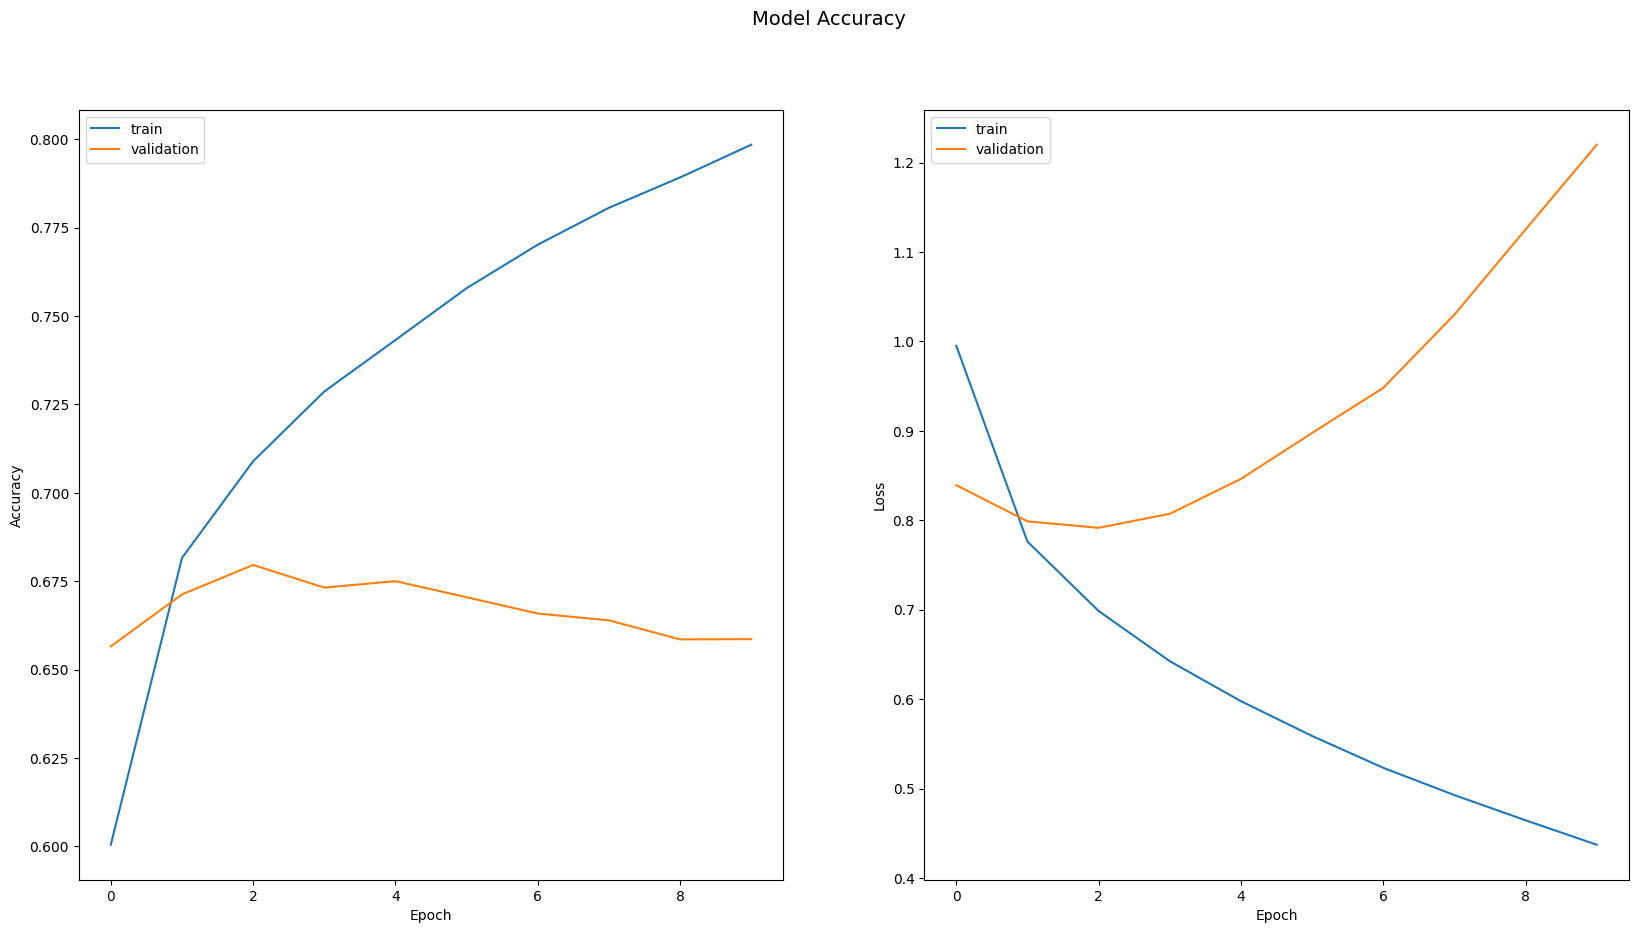

In [33]:
plot_learning_curves(history2)

# LSTM with GloVec Embedding

In [50]:
#Load Glovec
def read_data(file_name):
    # Open the specified file in read mode using a context manager
    with open(file_name, 'r') as f:
        # Initialize an empty set to store unique words
        word_vocab = set() 
        # Initialize an empty dictionary to store word vectors
        word2vector = {}
        # Iterate over each line in the file
        for line in f:
            # Remove leading and trailing whitespace from the line
            line_ = line.strip() 
            # Split the line into a list of words and their corresponding vector components
            words_Vec = line_.split()
            # Add the word to the vocabulary set
            word_vocab.add(words_Vec[0])
            # Store the word vector as a NumPy array in the dictionary, with the word as the key
            word2vector[words_Vec[0]] = np.array(words_Vec[1:], dtype=float)
    # Print the total number of unique words in the dataset
    print("Total Words in DataSet:", len(word_vocab))
    # Return the vocabulary set and the dictionary containing word vectors
    return word_vocab, word2vector

In [35]:
vocab, word_to_idx =read_data("/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt")


Total Words in DataSet: 400000


In [36]:
w_idx=tokenizer.word_index

# Creating an embedding matrix

Initialize an embedding matrix with pre-trained word embeddings and populate it with the embedding vectors for words present in the vocabulary. This embedding matrix can then be used as the initial weights for an embedding layer in a neural network model, enabling the model to utilize pre-trained word embeddings during training.

In [37]:
# Initialize an array of zeros with dimensions (vocab_size + 1, embedding_dim)
embedding_matrix = np.zeros((len(w_idx) + 1, 200))

# Iterate over each word and its index in the word-to-index dictionary
for word, i in w_idx.items():
    # Retrieve the embedding vector for the current word from the word-to-index dictionary
    embedding_vector = word_to_idx.get(word)
    # Check if the embedding vector is not None (i.e., the word exists in the embedding dictionary)
    if embedding_vector is not None:
        # Update the corresponding row in the embedding matrix with the embedding vector
        embedding_matrix[i] = embedding_vector

In [38]:
from keras.initializers import Constant
reset_tensorflow()
vocab_size = len(list(unique_words))
embedding_dim = 200


inputs = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(w_idx)+1, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix))(inputs)
x = Bidirectional(LSTM(128,return_sequences=True))(embedding_layer)
x = Bidirectional(LSTM(64,return_sequences=False))(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model3 = Model(inputs,outputs)
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 48, 200)        │     2,746,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,261,053 (12.44 MB)

 Trainable params: 3,261,053 (12.44 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model3.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])

In [40]:
reset_tensorflow()
history3 = model3.fit(X_train, 
                    y_train,
                   validation_data=(X_val,y_val),
                   epochs=10,
                   batch_size=256,
                   verbose=1)

Epoch 1/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5787 - loss: 1.0419 - val_accuracy: 0.6571 - val_loss: 0.8198
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6764 - loss: 0.7816 - val_accuracy: 0.6795 - val_loss: 0.7753
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7067 - loss: 0.7082 - val_accuracy: 0.6819 - val_loss: 0.7715
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7260 - loss: 0.6604 - val_accuracy: 0.6833 - val_loss: 0.7688
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7405 - loss: 0.6165 - val_accuracy: 0.6829 - val_loss: 0.7752
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7532 - loss: 0.5833 - val_accuracy: 0.6794 - val_loss: 0.8075
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7657 - loss: 0.5490 - val_accuracy: 0.6840 - val_loss: 0.8436
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7792 - loss: 0.5137 - 

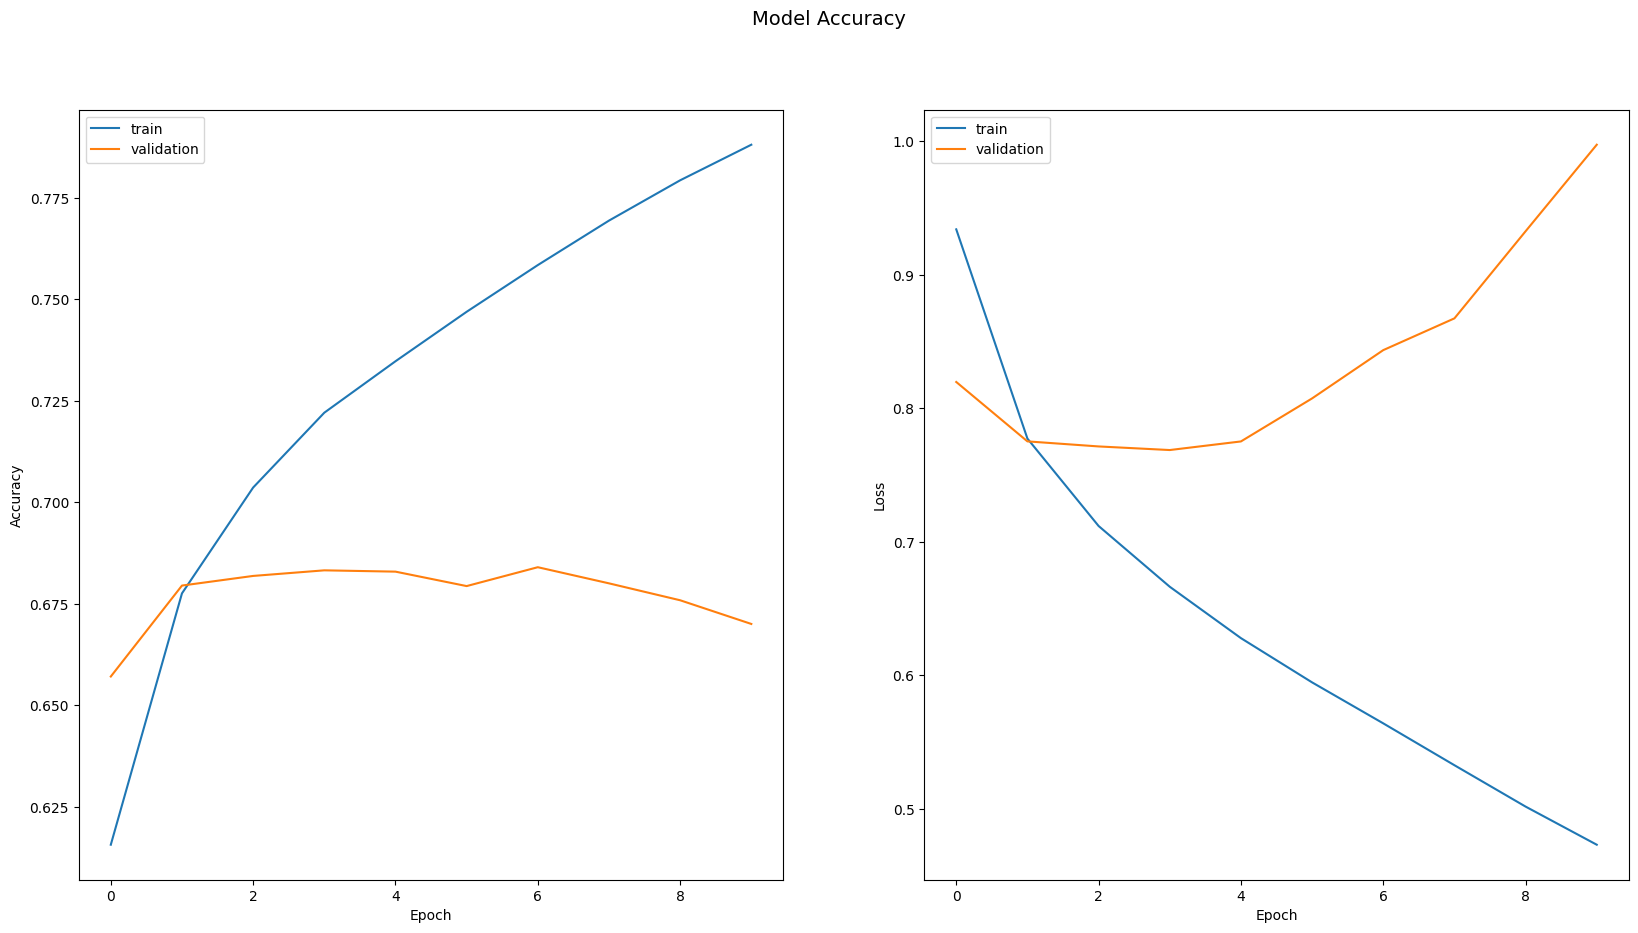

In [41]:
plot_learning_curves(history3)

# Prediction and Submissions

In [46]:
def prepare_submission(model, submission_file_path):    
    
    # Make predictions
    prediction = model.predict(test_data)
    prediction = np.argmax(prediction, axis=1)
    
    # Prepare submission DataFrame
    submission = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')
    submission['Sentiment'] = prediction
    
    # Save submission file
    submission.to_csv(submission_file_path, index=False)
    print(f"Submission file saved to {submission_file_path}")

In [ ]:
prepare_submission(model, 'LSTM_submission.csv'  )
prepare_submission(model1, 'RNN_submission.csv'  )
prepare_submission(model2, 'Bidirectional_LSTM_submission.csv'  )
prepare_submission(model3, 'Bidirectional_LSTM_Glovec_submission.csv'  )